#### Import libraries

In [1]:
import river
from river import datasets
from river import linear_model, tree
from river import drift, metrics
from river.datasets import synth
import numpy as np
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from frouros.metrics import PrequentialError
from sklearn.pipeline import Pipeline
from frouros.detectors.concept_drift.streaming.window_based.adwin import ADWIN
from frouros.detectors.concept_drift import DDM, DDMConfig
from frouros.detectors.concept_drift.streaming.statistical_process_control.ddm import DDM
from frouros.detectors.concept_drift.streaming.statistical_process_control.eddm import EDDM,EDDMConfig
from frouros.detectors.concept_drift.streaming.change_detection.page_hinkley import PageHinkley


#### Returns the DataFrame containing the generated data

In [3]:
def initialize_data(dp1, dp2, seed=42):
    """
    Initialize the dataset with specified drift position and seed.
    
    Parameters:
    - a (int): The start position where the drift occurs.
    - b (int): The end position where the drift occurs and also used as the limit.
    - seed (int): Random seed for reproducibility.
    
    Returns:
    - pd.DataFrame: DataFrame containing the generated data.
    """
    dataset = synth.FriedmanDrift(
        drift_type='gra',
        position=(dp1, dp2),
        seed=seed
    )
    data = []
    for i, (x, y) in enumerate(dataset):
        x_values = list(x.values())
        data.append(x_values + [y])
        if i >= dp2:  # Limiting to 'b' samples for simplicity
            break
    column_names = [f'x{i}' for i in range(1, len(x_values) + 1)] + ['y']
    df = pd.DataFrame(data, columns=column_names)
    return df

#### Split the Data into Training and Streaming Sets

In [5]:
def split_data(df, split):
    """
    Split the dataset into training, validation, and streaming sets.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the dataset.
    - split (int): Index in which we split the data in to train and tream.
    
    
    Returns:
    - train (pd.DataFrame): Training set.
    - val (pd.DataFrame): Validation set.
    - stream (pd.DataFrame): Streaming set.
    """
    # Split the DataFrame into train and remaining data
    train = df.iloc[:split]
    stream = df.iloc[split:]
    
    
    return train, stream


#### Set Up the Pipeline and Train the Model

In [7]:
def train_model(train,model):
    X_train = train.drop(columns='y').values
    y_train = train['y'].values
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)])
    pipeline.fit(X_train, y_train)
    return pipeline

#### Initialize and Update the Drift Detector

### DDM

In [9]:
def setup_ddm(warning_level=2.0, drift_level=3.0, min_num_instances=30):
    """
    Set up the DDM detector with specified configuration parameters.
    
    Parameters:
    - warning_level (float): The warning level for drift detection.
    - drift_level (float): The drift level for drift detection.
    - min_num_instances (int): Minimum number of instances before checking for concept drift.
    
    Returns:
    - detector: An instance of the DDM drift detector.
    """
    config = DDMConfig(
        warning_level=warning_level,
        drift_level=drift_level,
        min_num_instances=min_num_instances
    )
    detector = DDM(config=config)
    return detector

### EDDM

In [205]:
def setup_eddm(alpha=0.95, beta=0.9, level=2.0, min_num_misclassified_instances=30):
    """
    Set up the EDDM (Early Drift Detection Method) detector with specified configuration parameters.
    
    Parameters:
    - alpha (float): Warning zone value.
    - beta (float): Change zone value.
    - level (float): Level factor for drift detection.
    - min_num_misclassified_instances (int): Minimum number of misclassified instances to start detecting drift.
    
    Returns:
    - detector: An instance of the EDDM drift detector.
    """
    config = EDDMConfig(
        alpha=alpha,
        beta=beta,
        level=level,
        min_num_misclassified_instances=min_num_misclassified_instances
    )
    detector = EDDM(config=config)
    return detector

#### convert to a binary stream

In [998]:
def binary_stream(X, y, pipeline, threshold):
    """
    Converts y values and predicted y (y_pred) values into binary streams based on a given threshold and concatenates them.
    
    Parameters:
    - X (numpy array): An array of input feature values.
    - y (numpy array): An array of actual y values.
    - pipeline (object): A trained pipeline/model that can predict y values from X.
    - threshold (float): The threshold value used to convert y and y_pred values to binary.
    
    Returns:
    - numpy array: A concatenated array of binary y and binary y_pred values based on the threshold.
    """
    
    # Predict y_pred using the pipeline
    y_pred = pipeline.predict(X)
    
    # Convert y values to binary based on the threshold
    binary_y = np.where(y >= threshold, 1, 0)
    
    # Convert y_pred values to binary based on the threshold
    binary_y_pred = np.where(y_pred >= threshold, 1, 0)
    
   
    
    return   binary_y , binary_y_pred


#### Process the Streaming Data - frourous

In [1190]:
def detect_drift(binary_y, binary_y_pred,detector):
    """
    Detect concept drift using DDM based on binary streams of actual and predicted values.

    Parameters:
    - binary_y (numpy array): Binary stream of actual values (0 or 1).
    - binary_y_pred (numpy array): Binary stream of predicted values (0 or 1).

    Returns:
    - None: Prints drift detection information.
    """
    detected_drifts = []
    false_alarms = 0
    detection_delays = []
    y_preds = []
    errors = []
    
    # Flag to track if drift has been detected
    #drift_flag = False
    
    # Iterate through both streams
    for i in range(len(binary_y)):
        actual = binary_y[i]
        predicted = binary_y_pred[i]
        
        # Calculate error: 1 if prediction is incorrect, 0 if correct
        error = 1 if actual != predicted else 0
        metric_error = metric(error_value=error)
        errors.append(error)
        # Update the DDM detector with the binary error value
        _ = detector.update(value=error)
        
        # Check for drift and warning
        if detector.drift:
            #print(f"Concept drift detected at step {i}. Accuracy: {1 - metric_error:.4f}")
            #drift_flag = True
            detected_drifts.append(i + len(train))
            if (i + len(train) < odp) :
                false_alarms += 1
            else:
                detection_delays.append((i + len(train) - odp))
        
        #if detector.warning:
            #print(f"Warning detected at step {i}")
    # Calculate false alarm rate
    #if not drift_flag:
        #print("No concept drift detected")
        #print(f"Final accuracy: {1 - metric_error:.4f}\n")
    false_alarm_rate = (false_alarms / (odp-len(train))) * 100 if detected_drifts else 0
    detection_delay = detection_delays[0] if detection_delays else None
    
    
    return false_alarm_rate, detection_delay, detected_drifts,errors

    
#if not drift_flag:
#print("No concept drift detected")


def process_binary_stream(bin_stream, detector, odp):
    """
    Processes a binary stream through a drift detector and calculates false alarms, detection delays, and detected drifts.
    
    Parameters:
    - bin_stream (numpy array): A binary stream (0s and 1s) representing the input data for the drift detector.
    - detector (object): A drift detection object that has a method `update(value)` and a property `drift`.
    - odp (int): The onset of drift point. The index from which drifts are considered real and not false alarms.
    
    Returns:
    - false_alarm_rate (float): The rate of false alarms detected by the detector.
    - detection_delay (float or None): The delay from the onset of drift point to the first detected drift, or None if no drift is detected.
    - detected_drifts (list): A list of indices where drifts were detected.
    """
    detected_drifts = []
    false_alarms = 0
    detection_delays = []
    
    for i, value in enumerate(bin_stream):
        detector.update(value=value)  # Update the detector with the current binary value
        
        if detector.drift:
            detected_drifts.append(i + len(train))
            if (i + len(train) < odp) :
                false_alarms += 1
            else:
                detection_delays.append((i + len(train) - odp))
    
    # Calculate false alarm rate
    false_alarm_rate = (false_alarms / (odp-len(train))) * 100 if detected_drifts else 0
    detection_delay = detection_delays[0] if detection_delays else None
    
    
    return false_alarm_rate, detection_delay, detected_drifts

# Example usage
# bin_stream = your binary stream data (numpy array)
# detector = your drift detection object
# odp = your onset of drift point

# false_alarm_rate, detection_delay, detected_drifts = process_binary_stream(bin_stream, detector, odp)


def process_stream(X, y, pipeline, detector, metric, odp):
    detected_drifts = []
    false_alarms = 0
    detection_delays = []
    y_preds = []
    errors = []
    
   

   
    for i in range(len(X)):
        X_i = X[i].reshape(1, -1)
        y_i = y[i].reshape(1, -1)
        
        
        # Predict and calculate the error
        y_pred = pipeline.predict(X_i)
        y_preds.append(y_pred[0])
        error = mean_squared_error(y_true=y_i, y_pred=y_pred)
        metric_error = metric(error_value=error)
        # error = metric(error_value=mean_squared_error(y_true=y_i, y_pred=y_pred))
        errors.append(error)
    
        # Update Page Hinkley with the error (0 for correct, 1 for incorrect)
        # detector.update(value=1 if error > 0 else 0)
    
        # Step 4: Update the drift detector with the current error
        detector.update(value=error)
        
        # Check for detected drift
        if detector.drift:
           # print(f"Change detected at step {i + len(train)}")  # Adjusting index to match the full dataset
            detected_drifts.append(i + len(train))  # Adjusting index to match the full dataset
            
            # Determine if it's a false alarm or not
            if i + len(train) < odp[0]:  # Compare with the original drift point
                false_alarms += 1
            else:
                detection_delays.append((i + len(train)) - odp[0])
       
    

        
    print(f"False Alarms: {false_alarms:.2f}%")
    print(odp-len(train)  )
    false_alarm_rate = (false_alarms / (odp-len(train))) * 100 if detected_drifts else 0
    detection_delay = detection_delays[0] if detection_delays else None
    return false_alarm_rate, detection_delay, errors, detected_drifts


#### Plot Error distribution

In [15]:
def plot_errors(errors: List[float]) -> None:
    """
    Plot the Mean Squared Error (MSE) values over data points.

    Parameters:
    - errors (List[float]): List of MSE error values to plot.

    Returns:
    - None
    """
    plt.figure(figsize=(14, 7))
    plt.plot(range(len(errors)), errors, label="MSE Error", color='purple')
    plt.xlabel("Instance Index")
    plt.ylabel("Mean Squared Error")
    plt.title("Behavior of Mean Squared Error Over Data Points")
    plt.legend()
    plt.grid(True)
    plt.show()


#### Visualizing detected drifts against actual

In [17]:
def plot_drift_indicators(data_length: int, detected_drifts: List[int], odp: int):
    """
    Plot drift detection indicators and actual drift indicators.

    Parameters:
    - data_length (int): The length of the data array.
    - detected_drifts (List[int]): List of indices where drifts are detected.
    - odp (int): Index of the initial drift point.
    """
    # Create binary arrays for drift detection and odp
    drift_indicator = np.zeros(data_length)
    for drift_point in detected_drifts:
        if drift_point < data_length:
            drift_indicator[drift_point] = 1

    odp_indicator = np.zeros(data_length)
    for i in range(odp, data_length):
        odp_indicator[i] = 1

    # Plotting the drift indicator and odp indicator
    plt.figure(figsize=(12, 4))
    plt.plot(drift_indicator, label='Detected Drift Indicator', color='red', drawstyle='steps-post')
    plt.plot(odp_indicator, label='Actual Drift Indicator (ODP)', color='green', linestyle='-', drawstyle='steps-post')
    plt.xlabel('Index')
    plt.ylabel('Drift Detection (0 or 1)')
    plt.title('Drift Detection Indicator')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

## Main()

In [1386]:
a = 2000
b = 3000
df = initialize_data(a, b,42)

df.describe()

In [1389]:
split_index = 1000

In [1391]:
train,stream = split_data(df, split_index)

model=LinearRegression()

model=DecisionTreeRegressor()

model=RandomForestRegressor()

In [1393]:
model=SVR()

In [1395]:
pipeline=train_model(train,model)

detector=setup_ddm(warning_level=0.01, drift_level=0.1, min_num_instances=30)

detector=setup_eddm(alpha=0.95, beta=0.9, level=2.0, min_num_misclassified_instances=30)

In [1397]:
threshold=threshold = df["y"].mean()
print(threshold)

14.391379288840028


In [1399]:
odp=a

In [1401]:
X = stream.drop(columns='y').values
y = stream['y'].values

In [1403]:
binary_y , binary_y_pred=binary_stream(X, y, pipeline, threshold)

In [1172]:
false_alarm_rate, detection_delay, detected_drifts,errors=detect_drift(binary_y, binary_y_pred,detector)

Concept drift detected at step 29. Accuracy: 0.8458
Concept drift detected at step 30. Accuracy: 0.8612
Concept drift detected at step 31. Accuracy: 0.8751
Concept drift detected at step 32. Accuracy: 0.8876
Concept drift detected at step 33. Accuracy: 0.8988
Concept drift detected at step 34. Accuracy: 0.9089
Concept drift detected at step 35. Accuracy: 0.9180
Concept drift detected at step 36. Accuracy: 0.9262
Concept drift detected at step 37. Accuracy: 0.9336
Concept drift detected at step 38. Accuracy: 0.9403
Concept drift detected at step 39. Accuracy: 0.9462
Concept drift detected at step 40. Accuracy: 0.9516
Concept drift detected at step 41. Accuracy: 0.9564
Concept drift detected at step 42. Accuracy: 0.9608
Concept drift detected at step 43. Accuracy: 0.9647
Concept drift detected at step 44. Accuracy: 0.9682
Concept drift detected at step 45. Accuracy: 0.9714
Concept drift detected at step 46. Accuracy: 0.9743
Concept drift detected at step 47. Accuracy: 0.9769
Concept drif

In [1174]:

print(f"False alarm rate: {false_alarm_rate}")
print(f"Detection delay: {detection_delay}")

Detected drift points: [1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191

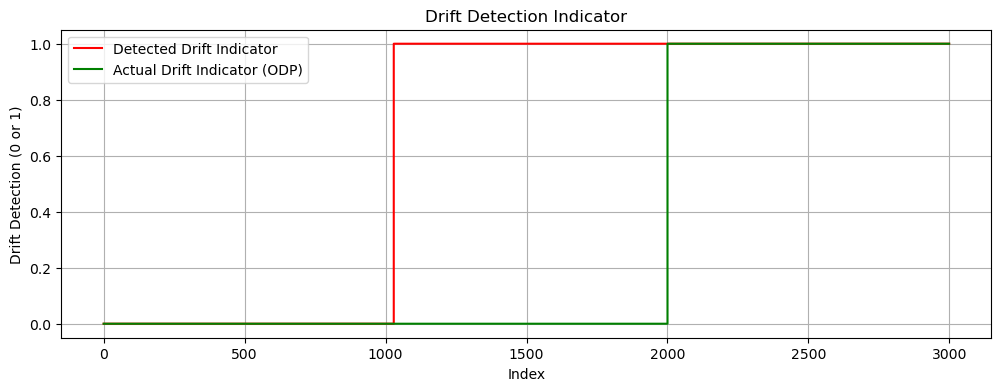

In [1176]:
plot_drift_indicators(b, detected_drifts, odp)

### optimum drift level - DDM

In [1270]:
def optimize_drift_level(binary_y, binary_y_pred,start,end,step_size,odp):
    best_drift_level = None
    best_false_alarm_rate = float('inf')
    best_detection_delay = float('inf')
    best_detected_drifts = []

    
    
    # Test various drift levels
    for drift_level in np.arange(start,end,step_size):  # Adjust drift level range and step as needed
        detector = setup_ddm(drift_level-0.05,drift_level,30)
        
        
        false_alarm_rate, detection_delay, detected_drifts,errors=detect_drift(binary_y, binary_y_pred,detector)

        print(f"Drift Level: {drift_level:.2f}")
        
        print(f"False Alarm Rate: {false_alarm_rate:.2f}%")
        print(f"Detection Delay: {detection_delay}")
        #print(f"Detected Drifts: {detected_drifts}\n")

        if false_alarm_rate < best_false_alarm_rate or (false_alarm_rate == best_false_alarm_rate and (detection_delay is None or detection_delay < best_detection_delay)):
            best_drift_level = drift_level
            best_false_alarm_rate = false_alarm_rate
            best_detection_delay = detection_delay
            best_detected_drifts = detected_drifts

    print(f"Best Drift Level: {best_drift_level}")
    print(f"Best False Alarm Rate: {best_false_alarm_rate}")
    print(f"Best Detection Delay: {best_detection_delay}")
    
    return best_detected_drifts
  

In [1295]:
start=0.1
end=5.0
step_size=0.2

In [1297]:
best_detected_drifts=optimize_drift_level(binary_y, binary_y_pred,start,end,step_size,odp)

Drift Level: 0.10
False Alarm Rate: 97.10%
Detection Delay: 0
Drift Level: 0.30
False Alarm Rate: 97.10%
Detection Delay: 0
Drift Level: 0.50
False Alarm Rate: 97.10%
Detection Delay: 0
Drift Level: 0.70
False Alarm Rate: 97.10%
Detection Delay: 0
Drift Level: 0.90
False Alarm Rate: 97.10%
Detection Delay: 0
Drift Level: 1.10
False Alarm Rate: 94.10%
Detection Delay: 0
Drift Level: 1.30
False Alarm Rate: 92.70%
Detection Delay: 0
Drift Level: 1.50
False Alarm Rate: 75.80%
Detection Delay: 0
Drift Level: 1.70
False Alarm Rate: 29.50%
Detection Delay: 25
Drift Level: 1.90
False Alarm Rate: 16.50%
Detection Delay: 46
Drift Level: 2.10
False Alarm Rate: 7.60%
Detection Delay: 73
Drift Level: 2.30
False Alarm Rate: 2.10%
Detection Delay: 94
Drift Level: 2.50
False Alarm Rate: 0.00%
Detection Delay: 105
Drift Level: 2.70
False Alarm Rate: 0.00%
Detection Delay: 157
Drift Level: 2.90
False Alarm Rate: 0.00%
Detection Delay: 180
Drift Level: 3.10
False Alarm Rate: 0.00%
Detection Delay: 235
Dr

### Optimum min miss - DDM

In [1244]:
start=30
end=800
step_size=50

In [1246]:
def optimize_mm_level(binary_y, binary_y_pred,start,end,step_size,odp):
    best_drift_level = None
    best_false_alarm_rate = float('inf')
    best_detection_delay = float('inf')
    best_detected_drifts = []

    
    
    # Test various drift levels
    for mm in np.arange(start,end,step_size):  # Adjust drift level range and step as needed
        detector = setup_ddm(1.0,1.7,mm)
        
        
        false_alarm_rate, detection_delay, detected_drifts,errors=detect_drift(binary_y, binary_y_pred,detector)

        print(f"min miss: {drift_level}")
        
        print(f"False Alarm Rate: {false_alarm_rate:.2f}%")
        print(f"Detection Delay: {detection_delay}")
        #print(f"Detected Drifts: {detected_drifts}\n")

        if false_alarm_rate < best_false_alarm_rate or (false_alarm_rate == best_false_alarm_rate and (detection_delay is None or detection_delay < best_detection_delay)):
            best_drift_level = drift_level
            best_false_alarm_rate = false_alarm_rate
            best_detection_delay = detection_delay
            best_detected_drifts = detected_drifts

    print(f"Best Drift Level: {best_drift_level}")
    print(f"Best False Alarm Rate: {best_false_alarm_rate}")
    print(f"Best Detection Delay: {best_detection_delay}")
    
    return best_detected_drifts
  

best_detected_drifts=optimize_mm_level(binary_y, binary_y_pred,start,end,step_size,odp)

### alpha - drift level EDDM

In [1405]:
start=0.5
end=0.99
step_size=0.05

In [1407]:
def optimize_drift_level_e(binary_y, binary_y_pred,start,end,step_size,odp):
    best_drift_level = None
    best_false_alarm_rate = float('inf')
    best_detection_delay = float('inf')
    best_detected_drifts = []

    
    
    # Test various drift levels
    for beta in np.arange(start,end,step_size):  # Adjust drift level range and step as needed
        detector = setup_eddm(beta+0.1,beta,2.0,30)
        
        
        false_alarm_rate, detection_delay, detected_drifts,errors=detect_drift(binary_y, binary_y_pred,detector)

        print(f"Beta: {beta:.2f}")
        
        print(f"False Alarm Rate: {false_alarm_rate:.2f}%")
        print(f"Detection Delay: {detection_delay}")
        #print(f"Detected Drifts: {detected_drifts}\n")

        

In [1409]:
optimize_drift_level_e(binary_y, binary_y_pred,start,end,step_size,odp)

Beta: 0.50
False Alarm Rate: 0.00%
Detection Delay: None
Beta: 0.55
False Alarm Rate: 0.00%
Detection Delay: None
Beta: 0.60
False Alarm Rate: 0.00%
Detection Delay: 902
Beta: 0.65
False Alarm Rate: 0.00%
Detection Delay: 608
Beta: 0.70
False Alarm Rate: 0.00%
Detection Delay: 445
Beta: 0.75
False Alarm Rate: 0.00%
Detection Delay: 302
Beta: 0.80
False Alarm Rate: 0.00%
Detection Delay: 228
Beta: 0.85
False Alarm Rate: 0.00%
Detection Delay: 132
Beta: 0.90
False Alarm Rate: 0.20%
Detection Delay: 77
Beta: 0.95
False Alarm Rate: 4.10%
Detection Delay: 31
